In [1]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import reptrvae

Using TensorFlow backend.


In [3]:
adata = sc.read('./data/alzPro_count.h5ad')
adata

AnnData object with n_obs × n_vars = 48 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [4]:
adata.obs['Group'].value_counts()

HET    24
WT     24
Name: Group, dtype: int64

In [5]:
sc.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=100)
sc.pp.log1p(adata, base=np.e)
#sc.pp.log1p(adata, base=1000)
#sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [227]:
#adata = adata[:, adata.var['highly_variable']]

In [6]:
adata

AnnData object with n_obs × n_vars = 48 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    uns: 'log1p'

In [7]:
adata.X.min(), adata.X.max()

(0.0, 19.760094)

In [8]:
adata.obs['Timepoint'].value_counts()

3m    16
6m    16
9m    16
Name: Timepoint, dtype: int64

In [9]:
os.makedirs("./data/", exist_ok=True)

In [10]:
adata.write_h5ad("./data/alzPro_normalized.h5ad")

In [11]:
special_cell_type = "3m"

In [12]:
cell_type_adata = adata[adata.obs["Timepoint"] == special_cell_type]

In [13]:
cell_type_adata.obs['Group'].value_counts()

HET    8
WT     8
Name: Group, dtype: int64

In [14]:
cell_type_adata.obs['Group'].cat.categories

Index(['HET', 'WT'], dtype='object')

In [15]:
sc.tl.rank_genes_groups(cell_type_adata, groups=['HET'], groupby="Group", reference='WT', n_genes=10)

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [16]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names']['HET']
top_genes

array(['O89051|ITM2B', 'P12023|A4', 'Q9EPW0|INP4A', 'Q9CQ89|CUTA',
       'P18242|CATD', 'Q61207|SAP', 'O88531|PPT1', 'P08226|APOE',
       'O88653|LTOR3', 'P47708|RP3A'], dtype=object)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


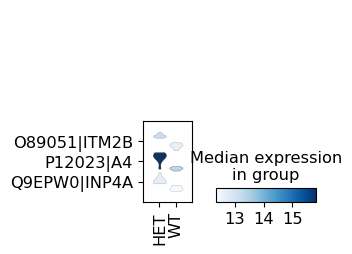

In [17]:
sc.pl.stacked_violin(cell_type_adata, groupby='Group', var_names=top_genes[:3], swap_axes=True)

## Viewing Results

In [18]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [19]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import reptrvae

In [20]:
sc.set_figure_params(dpi=200)

In [21]:
path_to_save = "./results/alzPro/"
sc.settings.figdir = path_to_save

In [22]:
specific_cell_type = "3m"

In [23]:
cell_type_key = "Timepoint"
condition_key = "Group"
target_condition = "HET"
conditions = ['WT', 'HET']

In [24]:
mode = 'normalized'
#mode = 'count'
adata = sc.read(f"./data/alzPro_{mode}.h5ad")
#adata.uns['log1p']["base"] = None
adata

AnnData object with n_obs × n_vars = 48 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    uns: 'log1p'

In [25]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [26]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
#cell_type_adata.uns['log1p']["base"] = None
cell_type_adata

View of AnnData object with n_obs × n_vars = 16 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts'
    uns: 'log1p'

In [27]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == 'WT']
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [28]:
ctrl_adata.obs['method'] = 'WT'
real_adata.obs['method'] = target_condition

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [29]:
trvae_reconstructed = sc.read(f"./data/reconstructed/trVAE_alzPro/{specific_cell_type}.h5ad")
#trvae_reconstructed.uns['log1p']["base"] = None
trvae_reconstructed

AnnData object with n_obs × n_vars = 16 × 2000
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'batch'
    var: 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

In [30]:
trvae_reconstructed.X[:8].min(), trvae_reconstructed.X[:8].max()

(0.0, 16.559727)

In [31]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"WT_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

ValueError: Length of passed value for var_names is 2969, but this AnnData has shape: (8, 2000)

In [ ]:
models = ctrl_adata.concatenate(real_adata, trvae_pred)
models.obs['method'].unique()

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


array(['WT', 'HET', 'trVAE'], dtype=object)

In [ ]:
models.var_names

Index(['A2A432|CUL4B', 'A2A699|F1712', 'A2AGT5|CKAP5', 'A2AJI0|MA7D1',
       'A2ALS5|RPGP1', 'A2RT62|FXL16', 'A6H5Z3|EXC6B', 'B0V2N1|PTPRS',
       'B1AXV0|FRS1L', 'B1AZP2|DLGP4',
       ...
       'Q9Z2I8|SUCB2', 'Q9Z2I9|SUCB1', 'Q9Z2Q6|SEPT5', 'Q9Z2U0|PSA7',
       'Q9Z2U1|PSA5', 'Q9Z2W8|GRIA4', 'Q9Z2W9|GRIA3', 'Q9Z2X1|HNRPF',
       'Q9Z2Y3|HOME1', 'Q9Z2Y8|PLPHP'],
      dtype='object', name='Accession', length=1729)

In [ ]:
sc.tl.rank_genes_groups(models, reference=target_condition, 
                       groupby="method", groups=['trVAE'],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(models, reference='trVAE',
                         groupby="method", groups=[target_condition],
                         key_added='down_reg_genes', n_genes=50)
up_genes = models.uns['up_reg_genes']['names']['trVAE']
down_genes = models.uns['down_reg_genes']['names'][target_condition]

In [ ]:
protein_up = up_genes[0]
print(protein_up)

P07309|TTHY


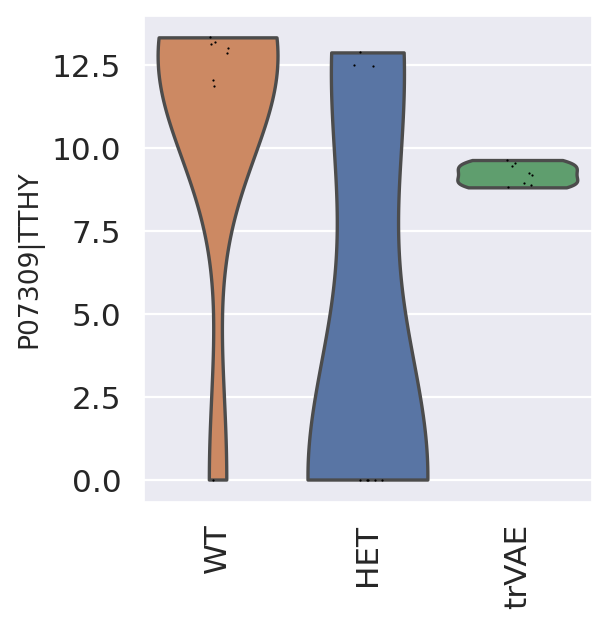

In [ ]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_up, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_best_model_cmpr.pdf",
             jitter=True,
            )

In [ ]:
protein_down = down_genes[0]
print(protein_down)

P35283|RAB12


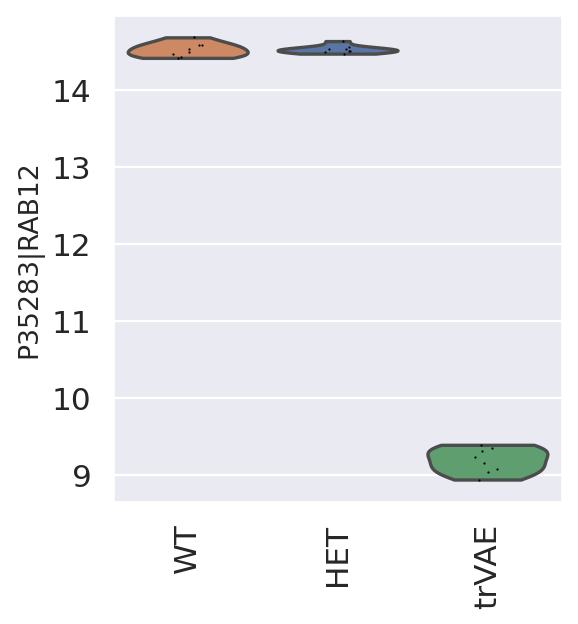

In [ ]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_down, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_worst_model_cmpr.pdf",
             jitter=True,
            )

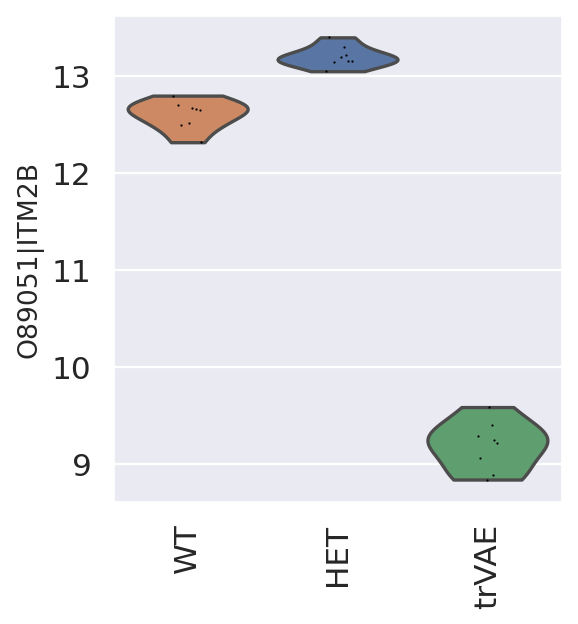

In [ ]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="O89051|ITM2B", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_standard_model_cmpr.pdf",
             jitter=True,
            )

### R^2 Plots

In [ ]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
#adata_pred.uns['log1p']["base"] = None
adata_pred

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 24 × 1729
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'n_counts', 'method', 'batch'

In [ ]:
sc.tl.rank_genes_groups(cell_type_adata, reference='WT', 
                       groupby=condition_key, groups=[target_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition,
                         groupby=condition_key, groups=['WT'],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][target_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names']['WT']

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [ ]:
top_genes = up_genes.tolist() + down_genes.tolist()

In [ ]:
len(top_genes)

100

reg_mean_top100: 0.6563714831627483
reg_mean_all: 0.7402274812668769


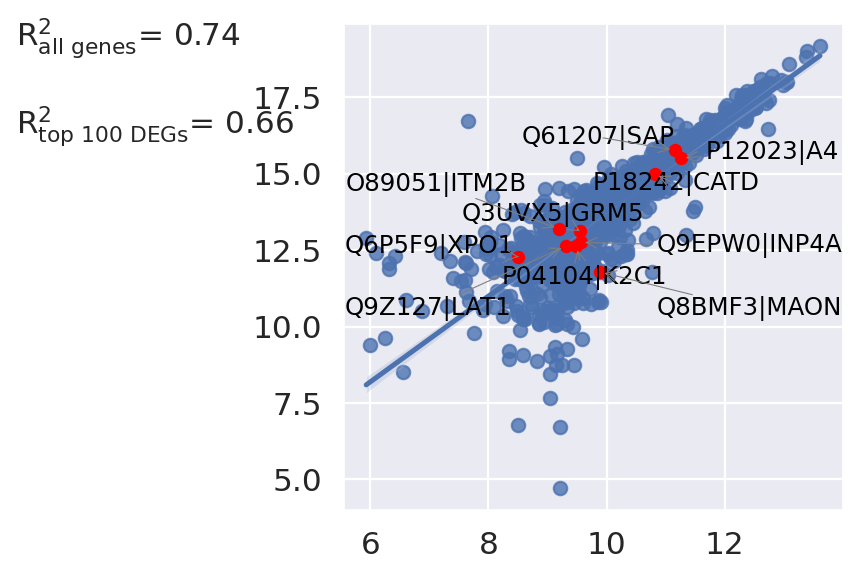

In [ ]:
reptrvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.016907591461259447
reg_var_all: 0.010469226778232293


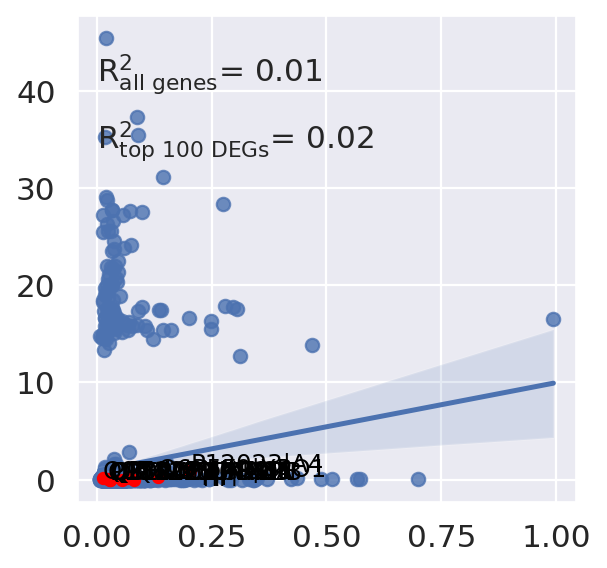

In [ ]:
reptrvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

In [ ]:
up_genes.tolist()

['O89051|ITM2B',
 'P12023|A4',
 'Q9EPW0|INP4A',
 'Q61207|SAP',
 'P18242|CATD',
 'Q9CQ89|CUTA',
 'P08226|APOE',
 'O88531|PPT1',
 'P47708|RP3A',
 'P30416|FKBP4',
 'Q9Z0X1|AIFM1',
 'Q9CQ22|LTOR1',
 'P10605|CATB',
 'Q8BZ98|DYN3',
 'A2AGT5|CKAP5',
 'P47857|PFKAM',
 'Q920E5|FPPS',
 'P55264|ADK',
 'P10518|HEM2',
 'Q9CPQ8|ATP5L',
 'Q91VD9|NDUS1',
 'P17751|TPIS',
 'P42669|PURA',
 'P57776|EF1D',
 'P70663|SPRL1',
 'Q99N28|CADM3',
 'P20152|VIME',
 'Q6PIE5|AT1A2',
 'Q61171|PRDX2',
 'Q3UGR5|HDHD2',
 'O88428|PAPS2',
 'Q8C0M9|ASGL1',
 'P16388|KCNA1',
 'P10649|GSTM1',
 'O35381|AN32A',
 'P56135|ATPK',
 'P60122|RUVB1',
 'Q6PA06|ATLA2',
 'P57722|PCBP3',
 'Q04447|KCRB',
 'Q9DBG6|RPN2',
 'P02802|MT1',
 'P61979|HNRPK',
 'Q80UP3|DGKZ',
 'Q08331|CALB2',
 'Q03265|ATPA',
 'P48036|ANXA5',
 'O70589|CSKP',
 'P42208|SEPT2',
 'P21619|LMNB2']

In [ ]:
down_genes.tolist()

['Q8BMF3|MAON',
 'P04104|K2C1',
 'Q3UVX5|GRM5',
 'Q9Z127|LAT1',
 'Q6P5F9|XPO1',
 'Q9EQF6|DPYL5',
 'Q8VDQ8|SIR2',
 'Q9JMA1|UBP14',
 'P35803|GPM6B',
 'Q7M6Y3|PICAL',
 'P31938|MP2K1',
 'Q99LD4|CSN1',
 'Q80ZJ1|RAP2A',
 'Q62188|DPYL3',
 'O88544|CSN4',
 'P57780|ACTN4',
 'O55100|SNG1',
 'P12849|KAP1',
 'Q5PR73|DIRA2',
 'P62746|RHOB',
 'Q922Q4|P5CR2',
 'P14094|AT1B1',
 'Q922J6|TSN2',
 'P19096|FAS',
 'Q6ZPE2|MTMR5',
 'Q62418|DBNL',
 'P23818|GRIA1',
 'Q9DB15|RM12',
 'Q9DBG3|AP2B1',
 'P61205|ARF3',
 'P07309|TTHY',
 'P32037|GTR3',
 'P20444|KPCA',
 'P62482|KCAB2',
 'O08756|HCD2',
 'Q80XI4|PI42B',
 'Q99JI6|RAP1B',
 'Q91YJ2|SNX4',
 'Q9Z2I2|FKB1B',
 'P16330|CN37',
 'Q9Z0H4|CELF2',
 'Q80YN3|BCAS1',
 'Q60996|2A5G',
 'O88737|BSN',
 'Q6PEB6|PHOCN',
 'Q7TQD2|TPPP',
 'Q8BSS9|LIPA2',
 'O35465|FKBP8',
 'P68404|KPCB',
 'Q9R0P9|UCHL1']